In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from astropy.io import fits
import scipy.sparse
import scipy.linalg
import time

from astropy.io import fits # [added to write outputs. C.M.H.]

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

kB = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G
e = 2.718281828459 # base of natural log
e_char = 1.602e-19 * c / 10 # electron charge in esu

z = 2
z2 = (1 + z) / 3
T_CMB *= 1+z # scale to CMB temperature at that redshift <-- C.M.H.

In [8]:
with open('rate_z2_10Mpc_new.pkl', 'rb') as f:
    rata_arr = pkl.load(f)
    
rate_arr = np.array(rata_arr)
rate_arr = rate_arr.reshape(400,400) # [i][j]: gamma[i] theta[j], rate_arr[-1] = nan
rate_trans = np.transpose(rate_arr) # [i][j]: theta[i] gamma[j], rate_trans[i][-1] = nan
rate_trans[:,-1]=0. # remove nan <-- C.M.H.

gamma_e_arr = np.logspace(8, 14, 400) * eV_to_erg / m_e / c**2 # lab-frame Lorentz factor of the electron produced
theta_e_arr = np.logspace(-8,0, 400)

In [3]:
def get_nij(i, j, t): # nij = dN / (dV dgammae_j dOmegae_i)
    Gamma_IC0 = 1.1e-18 * z2**4
    gamma_max_inv = 1. / gamma_e_arr[j] - Gamma_IC0 * t
    if gamma_max_inv>1e-99:
        gamma_max = 1./gamma_max_inv
    else:
        gamma_max = 1e99
        
    nij = 0
    
    for jp in range(j, 399):
        if gamma_e_arr[jp] <= gamma_max:
                
            sum_ij = (gamma_e_arr[jp] - gamma_e_arr[jp-1]) * rate_trans[i][jp]
            
            if gamma_e_arr[jp+1] > gamma_max:
                fraction = (gamma_max - gamma_e_arr[jp]) / (gamma_e_arr[jp+1] - gamma_e_arr[jp])
                sum_ij = sum_ij * fraction
            nij += sum_ij
    nij = nij / (Gamma_IC0 * gamma_e_arr[j]**2)
    return nij

In [4]:
def get_ni(i, nij): # integrate gamma_e (1/gamma_e) nij
    ni = 0
    for j in range(1, 400):
        sum_i = (gamma_e_arr[j] - gamma_e_arr[j-1]) / gamma_e_arr[j] * nij[i][j]
        ni += sum_i
    return ni

In [4]:
t_arr = [1e8, 1e9, 1e10, 1e11, 1e12, 1e13]
t_num = len(t_arr)

In [5]:
Omega_x = np.logspace(-8,0, 400).reshape(400, 1)

In [7]:
time_start = time.time()

nij_ori = np.zeros((t_num, 400, 400))

for k in range(t_num):
    print(f'time {k} {t_arr[k]:.1e}', end = ' ')
    
    for j in range(1, 400):
        for i in range(400):
            #print(get_nij(i, j, t_arr[k]))
            nij_ori[k][i][j-1] = get_nij(i, j, t_arr[k])
    print('t = ', (time.time() - time_start) / 60)
    
np.save('nij_no_diff.npy', nij_ori)

time 0 1.0e+08 t =  0.055830645561218264
time 1 1.0e+09 t =  0.11140819787979125
time 2 1.0e+10 t =  0.1714040478070577
time 3 1.0e+11 t =  0.24709587891896564
time 4 1.0e+12 t =  0.3549862821896871
time 5 1.0e+13 t =  0.5109185655911763


In [8]:
ni_ori = np.zeros((t_num, 400)) # about theta
for k in range(t_num):
    for i in range(400):
        ni_ori[k][i] = get_ni(i, nij_ori[k])

In [9]:
deriv_array = np.zeros((400,t_num))
for j in range(399):
    for jp in range(j,399):
        if j==jp:
            tr = 0.
        else:
            tr = np.arccosh(theta_e_arr[jp]/theta_e_arr[j])
        deriv_array[j,:] += 2 * theta_e_arr[j] * (ni_ori[:,jp+1]-ni_ori[:,jp])/(theta_e_arr[jp+1]-theta_e_arr[jp])          * (np.arccosh(theta_e_arr[jp+1]/theta_e_arr[j]) - tr)
mc2_ori = np.zeros((400, t_num+1))
mc2_ori[:,0] = theta_e_arr
mc2_ori[:,1:] = deriv_array
np.save('distribution_no_diff.npy', mc2_ori)

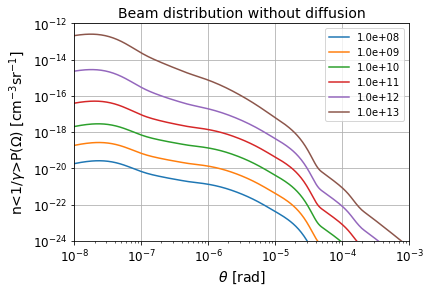

In [10]:
for i in range(t_num):
    plt.plot(Omega_x, -mc2_ori[:, 1+i], label=f'{t_arr[i]:.1e}')
    
plt.legend(loc = 'upper right')
plt.title('Beam distribution without diffusion', fontsize=14)
plt.xlabel(r'$\theta$ [rad]', fontsize=14)
plt.ylabel('n<1/$\gamma$>P($\Omega$) [$\mathrm{cm}^{-3}\mathrm{sr}^{-1}$]', fontsize=14)
plt.xlim([1e-8, 1e-3])
plt.ylim([1e-24, 1e-12])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
#plt.savefig('coulomb_scattering.pdf', bbox_inches='tight')
plt.show()

In [11]:
def calculate_solid_angles(theta):
    # theta_half[i] = theta[i-1/2]
    theta_half = (theta[1:] + theta[:-1]) / 2
    theta_half = np.concatenate([[theta[0]/2], theta_half, [3*theta[-1]/2 - theta[-2]/2]])

    Omega = 2 * np.pi * (theta_half[2:]**2 - theta_half[:-2]**2) / 2  # solid angles of annulus
    Omega = np.concatenate([Omega, [2 * np.pi * (theta[-1]**2 - theta_half[-2]**2)]])  # add the last circle

    return Omega, theta_half

In [12]:
Omega, theta_half = calculate_solid_angles(theta_e_arr)

In [13]:
M = np.zeros((400, 400))

for i in range(400):
    for j in range(400):
        if j == i + 1:
            M[i, j] = -2 * np.pi / Omega[i] * theta_half[i+1] / (theta_e_arr[i+1] - theta_e_arr[i])
        if j == i - 1:
            M[i, j] = -2 * np.pi / Omega[i] * theta_half[i] / (theta_e_arr[i] - theta_e_arr[i-1])
for i in range(1,399):
    M[i, i] = 2 * np.pi / Omega[i] * (theta_half[i+1] / (theta_e_arr[i+1] - theta_e_arr[i]) + theta_half[i] / (theta_e_arr[i] - theta_e_arr[i-1]))

M[0,0] = -M[1,0]*Omega[1]/Omega[0]
M[-1,-1] = -M[-2,-1]*Omega[-2]/Omega[-1]

In [14]:
P = np.diag(np.sqrt(1/Omega))
L = np.linalg.inv(P)@M@P
eigenvalues_L, eigenvectors_L = np.linalg.eigh(L)
R_L = eigenvectors_L.copy()
lambda_l = eigenvalues_L.copy()

In [15]:
prefix_sums = np.load("prefix_sums_new.npy")

In [16]:
def get_nij(i, j, t, M_expm): # nij = dN / (dV dgammae_j dOmegae_i)
    Gamma_IC0 = 1.1e-18 * z2**4
    gamma_max_inv = 1. / gamma_e_arr[j] - Gamma_IC0 * t
    if gamma_max_inv>1e-99:
        gamma_max = 1./gamma_max_inv
    else:
        gamma_max = 1e99
        
    nij = 0
    
    for jp in range(j, 399):
        if gamma_e_arr[jp] <= gamma_max:
            # THIS IS A COMMENT: rate_trans_smoothed = M_expm @ rate_trans
            # Then, rate_trans_smoothed[i][jp] is the dot product of M_expm[jp][i] and rate_trans[:, jp]
            rate_trans_smoothed_ijp = np.dot(M_expm[jp, i, :], rate_trans[:, jp])
                
            sum_ij = (gamma_e_arr[jp] - gamma_e_arr[jp-1]) * rate_trans_smoothed_ijp
            
            if gamma_e_arr[jp+1] > gamma_max:
                fraction = (gamma_max - gamma_e_arr[jp]) / (gamma_e_arr[jp+1] - gamma_e_arr[jp])
                sum_ij = sum_ij * fraction
            nij += sum_ij
    nij = nij / (Gamma_IC0 * gamma_e_arr[j]**2)
    return nij

In [17]:
time_start = time.time()

nij = np.zeros((t_num, 400, 400))
    
for j in range(1, 400):
    print(f'j = {j}, t = {(time.time() - time_start) / 60}')
    M_expm = np.zeros((400, 400, 400))
    for jp in range(j, 399):
        theta_rms = np.sqrt(prefix_sums[j] - prefix_sums[jp+1])
        M_expm[jp] = P@R_L@np.diag(np.exp(-theta_rms**2/4*lambda_l))@R_L.T@np.linalg.inv(P)
        if np.isnan(M_expm[jp,:,:].any()): print('test', j, jp, np.isnan(M_expm[jp,:,:].any()))
    #print('t = ', (time.time() - time_start) / 60)

    for k in range(t_num):
        #print(f'time {k} {t_arr[k]:.1e}', end = ' ')
        for i in range(400):
            nij[k][i][j-1] = get_nij(i, j, t_arr[k], M_expm)
print('t = ', (time.time() - time_start) / 60)

np.save('nij_diff.npy', nij)

j = 1, t = 7.671117782592773e-05
j = 2, t = 0.09550747871398926
j = 3, t = 0.19038567940394083
j = 4, t = 0.29524323145548503
j = 5, t = 0.39716704686482746
j = 6, t = 0.49606106281280515
j = 7, t = 0.6036113977432251
j = 8, t = 0.7199987649917603
j = 9, t = 0.8284798781077067
j = 10, t = 0.9331178983052572
j = 11, t = 1.0305371125539144
j = 12, t = 1.1379170139630637
j = 13, t = 1.245465099811554
j = 14, t = 1.3438591798146566
j = 15, t = 1.453826646010081
j = 16, t = 1.5573242465655008
j = 17, t = 1.6453255613644917
j = 18, t = 1.7441470623016357
j = 19, t = 1.8378957112630208
j = 20, t = 1.946164115269979
j = 21, t = 2.05889599720637
j = 22, t = 2.159764877955119
j = 23, t = 2.254179112116496
j = 24, t = 2.3578567504882812
j = 25, t = 2.4600934465726216
j = 26, t = 2.553257477283478
j = 27, t = 2.6862549940745035
j = 28, t = 2.7811821818351747
j = 29, t = 2.8676091273625692
j = 30, t = 2.967218514283498
j = 31, t = 3.0572933316230775
j = 32, t = 3.203460729122162
j = 33, t = 3.29569

In [14]:
nij_diff = np.load('nij_diff.npy')
print(nij_diff)

[[[4.85113120e-32 5.34403259e-32 5.89377457e-32 ... 7.01447794e-31
   0.00000000e+00 0.00000000e+00]
  [4.85113120e-32 5.34403259e-32 5.89377457e-32 ... 5.87949540e-31
   0.00000000e+00 0.00000000e+00]
  [4.85113120e-32 5.34403259e-32 5.89377457e-32 ... 4.91812938e-31
   0.00000000e+00 0.00000000e+00]
  ...
  [4.28306107e-46 3.81744436e-46 3.40168732e-46 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [3.15561425e-46 2.81253718e-46 2.50739277e-46 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [2.32646715e-46 2.07363002e-46 1.84896309e-46 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[4.85113215e-31 5.34403368e-31 5.89377582e-31 ... 1.16381674e-30
   0.00000000e+00 0.00000000e+00]
  [4.85113215e-31 5.34403368e-31 5.89377582e-31 ... 9.75504556e-31
   0.00000000e+00 0.00000000e+00]
  [4.85113215e-31 5.34403368e-31 5.89377582e-31 ... 8.15998192e-31
   0.00000000e+00 0.00000000e+00]
  ...
  [4.28306191e-45 3.81744514e-45 3.40168804e-45 ... 0.00000000e+00
   0.00000

In [16]:
print(np.min(nij_diff))

-9.375492369351535e-32


In [21]:
ni = np.zeros((t_num, 400)) # about theta
for k in range(t_num):
    for i in range(400):
        ni[k][i] = get_ni(i, nij[k])

In [24]:
deriv_array = np.zeros((400,t_num))
for j in range(399):
    for jp in range(j,399):
        if j==jp:
            tr = 0.
        else:
            tr = np.arccosh(theta_e_arr[jp]/theta_e_arr[j])
        deriv_array[j,:] += 2 * theta_e_arr[j] * (ni[:,jp+1]-ni[:,jp])/(theta_e_arr[jp+1]-theta_e_arr[jp])          * (np.arccosh(theta_e_arr[jp+1]/theta_e_arr[j]) - tr)
mc2 = np.zeros((400, t_num+1))
mc2[:,0] = theta_e_arr
mc2[:,1:] = deriv_array
np.save('distribution_diff.npy', mc2)

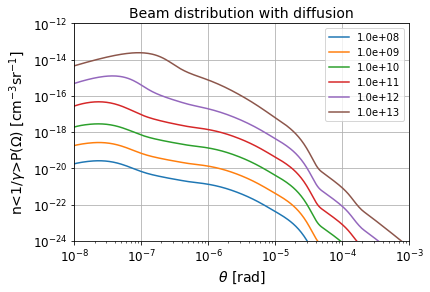

In [23]:
for i in range(t_num):
    plt.plot(Omega_x, -mc2[:, 1+i], label=f'{t_arr[i]:.1e}')
    
plt.legend(loc = 'upper right')
plt.title('Beam distribution with diffusion', fontsize=14)
plt.xlabel(r'$\theta$ [rad]', fontsize=14)
plt.ylabel('n<1/$\gamma$>P($\Omega$) [$\mathrm{cm}^{-3}\mathrm{sr}^{-1}$]', fontsize=14)
plt.xlim([1e-8, 1e-3])
plt.ylim([1e-24, 1e-12])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
#plt.savefig('coulomb_scattering.pdf', bbox_inches='tight')
plt.show()

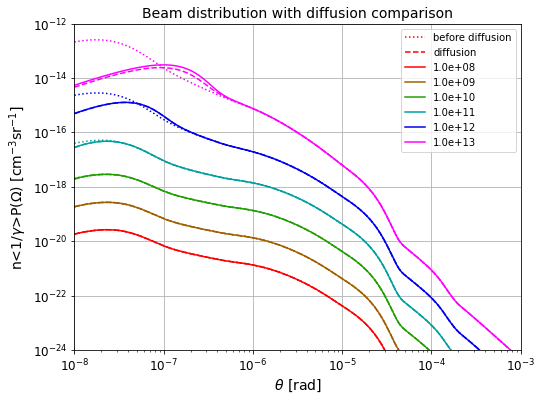

In [12]:
import numpy as np
import matplotlib.pyplot as plt

t_arr = [1e8, 1e9, 1e10, 1e11, 1e12, 1e13]
t_num = len(t_arr)
Omega_x = np.logspace(-8,0, 400).reshape(400, 1)

dis_no_diff = np.load('distribution_no_diff.npy')
dis_diff = np.load('distribution_diff.npy')
dis_col = np.loadtxt('./IGMCR_cleanup/deriv_array_final.dat')


color = [
    "#ff0000",  # Line 1: Red
    "#a06000",  # Line 2: Brown/Orange
    "#20a000",  # Line 3: Green
    "#00a0a0",  # Line 4: Teal
    "#0000ee",  # Line 5: Blue
    "#ff00ff"   # Line 6: Magenta
]

plt.figure(figsize=(8,6))

for i in range(t_num):
    if i == 0:
        plt.plot(Omega_x, -dis_no_diff[:, 1+i], ':', color=color[i], label=f'before diffusion')
        plt.plot(Omega_x, -dis_diff[:, 1+i], '--', color=color[i], label=f'diffusion')
    else:
        plt.plot(Omega_x, -dis_no_diff[:, 1+i], ':', color=color[i])
        plt.plot(Omega_x, -dis_diff[:, 1+i], '--', color=color[i])
    plt.plot(Omega_x, -dis_col[:, 1+i], color=color[i], label=f'{t_arr[i]:.1e}')
    
plt.legend(loc = 'upper right')
plt.title('Beam distribution with diffusion comparison', fontsize=14)
plt.xlabel(r'$\theta$ [rad]', fontsize=14)
plt.ylabel('n<1/$\gamma$>P($\Omega$) [$\mathrm{cm}^{-3}\mathrm{sr}^{-1}$]', fontsize=14)
plt.xlim([1e-8, 1e-3])
plt.ylim([1e-24, 1e-12])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
#plt.savefig('coulomb_scattering.pdf', bbox_inches='tight')
plt.show()

In [11]:
print(dis_diff[:, 1:])
print()
print(dis_col[:,1:])

[[-1.80406558e-20 -1.83242778e-19 -1.92826470e-18 -2.80027349e-17
  -4.93448258e-16 -4.62905345e-15]
 [-1.88715470e-20 -1.91733612e-19 -2.02830363e-18 -2.95947244e-17
  -5.20740269e-16 -4.86757773e-15]
 [-1.96061463e-20 -1.99229705e-19 -2.12105948e-18 -3.11829466e-17
  -5.48933685e-16 -5.11652629e-15]
 ...
 [-5.27759896e-46 -5.27760049e-45 -5.27761588e-44 -5.27776979e-43
  -5.27930948e-42 -5.29475083e-41]
 [-2.99391850e-46 -2.99391937e-45 -2.99392810e-44 -2.99401545e-43
  -2.99488928e-42 -3.00365278e-41]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]

[[-1.80406558e-20 -1.83242802e-19 -1.92846644e-18 -2.80260214e-17
  -4.96805015e-16 -5.45818546e-15]
 [-1.88715470e-20 -1.91733618e-19 -2.02850168e-18 -2.96193032e-17
  -5.24285640e-16 -5.73807573e-15]
 [-1.96061463e-20 -1.99229702e-19 -2.12124371e-18 -3.12086799e-17
  -5.52673416e-16 -6.03030718e-15]
 ...
 [-5.27759896e-46 -5.27760049e-45 -5.27761588e-44 -5.27776979e-43
  -5.27930948